In [1]:
import sys
sys.path.append('../..'); sys.path.append('../'); 

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
import utils
import imageio

2023-05-15 15:32:42.425638: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-15 15:32:42.634799: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-05-15 15:32:42.678719: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-05-15 15:32:43.422323: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; 

In [2]:
dat = np.load('imgs_size/RMTS_size_pretrain.npz')
X = dat['x']
y = dat['y']
X = 255 - X
X = np.expand_dims(X, axis=4)
print(X.shape, y.shape)

(200, 2, 32, 32, 1) (200,)


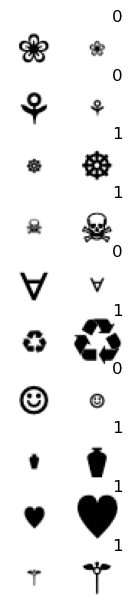

In [3]:
def display_sample(X, y, to_show=5):
    seq_len = int(X.shape[1]/2)
    fig, axarr = plt.subplots(to_show, 2*seq_len, figsize=(1.5*seq_len, .75*to_show))
    plt.rcParams['axes.titlepad'] = -14  
    for i in range(to_show):
        ind = np.random.choice(range(len(X)), 1)[0]
        for j in range(2*seq_len):
            axarr[i,j].imshow(X[i,j], cmap='gray_r')
            axarr[i,j].axis('off')
            if (j == 2*seq_len-1):
                axarr[i,j].set_title('%d' % y[i], loc='right')
    plt.show()


display_sample(X, y, to_show=10)

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10)
X_train.shape, X_test.shape

((180, 2, 32, 32, 1), (20, 2, 32, 32, 1))

In [5]:
from simplest_abstractor import CnnEncoder
from abstracters import SimpleAbstractor, RelationalAbstracter
from abstractor import Abstractor
from transformer_modules import Encoder
from tensorflow.keras import layers

## Abstractor

In [6]:
class CnnEncoder(tf.keras.Model):
    def __init__(self, ff_dim1=64, ff_dim2=64, name='cnn_encoder'):
        super().__init__(name=name)

        self.conv_layer1 = layers.Conv2D(32, (2, 2), activation='relu', name='%s/conv_layer1' % name)
        self.pool_layer1 = layers.MaxPooling2D((2, 2))
        self.conv_layer2 = layers.Conv2D(32, (2, 2), activation='relu', name='%s/conv_layer2' % name)
        self.pool_layer2 = layers.MaxPooling2D((2, 2))
        self.flatten = layers.Flatten()
        #self.dense1 = layers.Dense(ff_dim1, activation='relu')
        self.dense2 = layers.Dense(ff_dim2, activation='relu', name='%s/dense_layer' % name)
        self.normalize = layers.LayerNormalization(center=False, scale=False, epsilon=1e-6)

    def call(self, inputs):
        source = inputs
        x = self.conv_layer1(source)
        x = self.pool_layer1(x)
        x = self.conv_layer2(x)
        x = self.pool_layer2(x)
        x = self.flatten(x)
        #x = self.dense1(x)
        x = self.dense2(x)
        outputs = self.normalize(x)
        return outputs


In [7]:
embedding_dim = 64
# abstractor_kwargs = dict(
#     num_layers=1, 
#     num_heads=1, 
#     key_dim=64,
#     # symbol_dim=10,
#     dff=None,
#     attn_use_res=False,
#     attn_use_layer_norm=False,
#     use_pos_embedding=False,
#     mha_activation_type='softmax',
#     dropout_rate=0.1)

abstractor_kwargs = dict(
        num_layers=1,
        rel_dim=1,
        symbol_dim=10,
        proj_dim=64,
        symmetric_rels=False,
        encoder_kwargs=None,
        rel_activation_type='softmax',
        use_self_attn=False,
        use_layer_norm=False,
        dropout_rate=0.1,)

class AbstractorRMTSModel(tf.keras.Model):
    def __init__(self, embedding_dim, abstractor_kwargs, name=None):
        super().__init__(name=name)
        self.cnn_encoder = CnnEncoder(ff_dim2=embedding_dim, name='cnn_encoder')
        # self.cnn_embedder = layers.TimeDistributed(cnn_encoder, name='cnn_embedder')
        self.cnn_encoder.trainable = False
        # self.abstractor = SimpleAbstractor(**abstractor_kwargs)
        self.abstractor = Abstractor(**abstractor_kwargs)
        self.flatten = layers.Flatten()
        self.hidden_dense = layers.Dense(32, activation='relu', name='hidden_layer')
        self.final_layer = layers.Dense(1, activation='sigmoid', name='final_layer')
    
    def call(self, inputs):
        x = tf.map_fn(self.cnn_encoder, inputs)
        x = self.abstractor(x)
        x = self.flatten(x)
        x = self.hidden_dense(x)
        x = self.final_layer(x)

        return x

loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, name='binary_crossentropy')
create_opt = lambda : tf.keras.optimizers.Adam(learning_rate=0.001)

abstractor_model = AbstractorRMTSModel(embedding_dim, abstractor_kwargs, name='rmts_abstractor')
abstractor_model.compile(loss='binary_crossentropy', optimizer=create_opt(), metrics=['binary_accuracy'])
abstractor_model(X_train[:32])
abstractor_model.summary()

2023-05-15 15:32:46.451696: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-15 15:32:47.160590: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 39 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:1c:00.0, compute capability: 8.6
2023-05-15 15:32:48.013327: E tensorflow/stream_executor/cuda/cuda_dnn.cc:389] Could not create cudnn handle: CUDNN_STATUS_INTERNAL_ERROR
2023-05-15 15:32:48.013426: W tensorflow/core/framework/op_kernel.cc:1780] OP_REQUIRES failed at conv_ops.cc:1134 : UNIMPLEMENTED: DNN library is not found.


UnimplementedError: Exception encountered when calling layer "cnn_encoder/conv_layer1" "                 f"(type Conv2D).

{{function_node __wrapped__Conv2D_device_/job:localhost/replica:0/task:0/device:GPU:0}} DNN library is not found. [Op:Conv2D]

Call arguments received by layer "cnn_encoder/conv_layer1" "                 f"(type Conv2D):
  • inputs=tf.Tensor(shape=(2, 32, 32, 1), dtype=float32)

In [10]:
history = abstractor_model.fit(X_train, y_train, validation_data=(X_train, y_train), epochs=150, verbose=1, batch_size=128)

Epoch 1/150
2/2 [==============================] - 3s 526ms/step - loss: 0.7012 - binary_accuracy: 0.5222 - val_loss: 0.6894 - val_binary_accuracy: 0.5278
Epoch 2/150
2/2 [==============================] - 0s 171ms/step - loss: 0.6891 - binary_accuracy: 0.5056 - val_loss: 0.6858 - val_binary_accuracy: 0.5278
Epoch 3/150
2/2 [==============================] - 0s 172ms/step - loss: 0.6962 - binary_accuracy: 0.5167 - val_loss: 0.6821 - val_binary_accuracy: 0.5278
Epoch 4/150
2/2 [==============================] - 0s 173ms/step - loss: 0.6841 - binary_accuracy: 0.5556 - val_loss: 0.6786 - val_binary_accuracy: 0.5278
Epoch 5/150
2/2 [==============================] - 0s 169ms/step - loss: 0.6905 - binary_accuracy: 0.5278 - val_loss: 0.6751 - val_binary_accuracy: 0.5278
Epoch 6/150
2/2 [==============================] - 0s 175ms/step - loss: 0.6808 - binary_accuracy: 0.5556 - val_loss: 0.6713 - val_binary_accuracy: 0.5278
Epoch 7/150
2/2 [==============================] - 0s 166ms/step - los

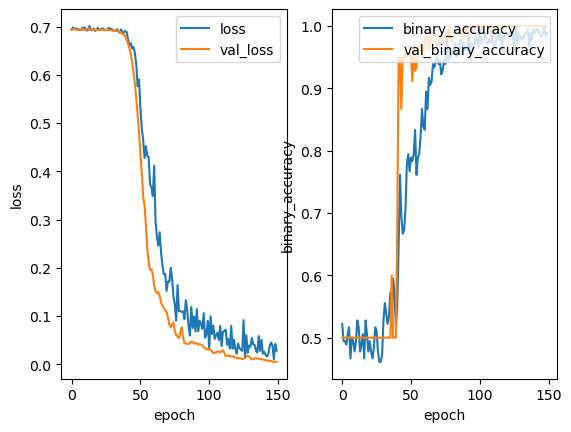

In [75]:
utils.plot_history(history, ('loss', 'binary_accuracy'));


In [76]:
out = abstractor_model(X_train)
yhat = np.array([int(o) for o in np.round(np.squeeze(out.numpy()))])
print('train accuracy: %.2f%%\n' % (100*np.mean(yhat==y_train)))

train accuracy: 100.00%



In [77]:
out = abstractor_model(X_test)
yhat = np.array([int(o) for o in np.round(np.squeeze(out.numpy()))])
100*np.mean(yhat==y_test)
print('test accuracy: %.2f%%\n' % (100*np.mean(yhat==y_test)))

test accuracy: 100.00%



In [78]:
out = abstractor_model.save_weights("models/larger_than_relation_weights")

In [80]:
abstractor_model_ = AbstractorRMTSModel(embedding_dim, abstractor_kwargs, name='rmts_abstractor')
abstractor_model_.compile(loss='binary_crossentropy', optimizer=create_opt(), metrics=['binary_accuracy'])
abstractor_model_(X_train[:32])
abstractor_model_.load_weights('models/larger_than_relation_weights')
abstractor_model_.summary()

Model: "rmts_abstractor"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 cnn_encoder (CnnEncoder)    multiple                  104704    
                                                                 
 simple_abstractor (SimpleAb  multiple                 16768     
 stractor)                                                       
                                                                 
 flatten_42 (Flatten)        multiple                  0         
                                                                 
 hidden_layer (Dense)        multiple                  4128      
                                                                 
 final_layer (Dense)         multiple                  33        
                                                                 
Total params: 125,633
Trainable params: 20,929
Non-trainable params: 104,704
________________________________________

In [81]:
out = abstractor_model_(X)
yhat = np.array([int(o) for o in np.round(np.squeeze(out.numpy()))])
print('Overall accuracy: %.2f%%\n' % (100*np.mean(yhat==y)))

Overall accuracy: 100.00%



## Transformer

In [100]:
embedding_dim = 32
encoder_kwargs = dict(
    num_layers=2, 
    num_heads=8, 
    dff=32,
    dropout_rate=0.1)

class TransformerRMTSModel(tf.keras.Model):
    def __init__(self, embedding_dim, abstractor_kwargs, name=None):
        super().__init__(name=name)
        self.cnn_encoder = CnnEncoder(ff_dim2=embedding_dim, name='cnn_encoder')
        # self.cnn_embedder = layers.TimeDistributed(cnn_encoder, name='cnn_embedder')
        # self.cnn_encoder.trainable = False
        self.encoder = Encoder(**encoder_kwargs)
        self.flatten = layers.Flatten()
        self.hidden_dense = layers.Dense(32, activation='relu', name='hidden_layer')
        self.final_layer = layers.Dense(1, activation='sigmoid', name='final_layer')
    
    def call(self, inputs):
        x = tf.map_fn(self.cnn_encoder, inputs)
        x = self.encoder(x)
        x = x[:,0,:]#self.flatten(x)
        x = self.hidden_dense(x)
        x = self.final_layer(x)

        return x

loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, name='binary_crossentropy')
create_opt = lambda : tf.keras.optimizers.Adam(learning_rate=0.001)

transformer_model = TransformerRMTSModel(embedding_dim, abstractor_kwargs, name='rmts_abstractor')
transformer_model.compile(loss='binary_crossentropy', optimizer=create_opt(), metrics=['binary_accuracy'])
transformer_model(X_train[:32])
transformer_model.summary()

Model: "rmts_abstractor"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 cnn_encoder (CnnEncoder)    multiple                  54496     
                                                                 
 encoder (Encoder)           multiple                  71616     
                                                                 
 flatten_59 (Flatten)        multiple                  0 (unused)
                                                                 
 hidden_layer (Dense)        multiple                  1056      
                                                                 
 final_layer (Dense)         multiple                  33        
                                                                 
Total params: 127,201
Trainable params: 127,201
Non-trainable params: 0
_________________________________________________________________


In [101]:
history = transformer_model.fit(X_train, y_train, validation_data=(X_train, y_train), epochs=250, verbose=1, batch_size=256)

Epoch 1/250
1/1 [==============================] - 3s 3s/step - loss: 0.7226 - binary_accuracy: 0.5278 - val_loss: 1.0151 - val_binary_accuracy: 0.5000
Epoch 2/250
1/1 [==============================] - 0s 171ms/step - loss: 0.9765 - binary_accuracy: 0.5000 - val_loss: 0.7792 - val_binary_accuracy: 0.5000
Epoch 3/250
1/1 [==============================] - 0s 168ms/step - loss: 0.7838 - binary_accuracy: 0.4833 - val_loss: 0.6933 - val_binary_accuracy: 0.5000
Epoch 4/250
1/1 [==============================] - 0s 169ms/step - loss: 0.7036 - binary_accuracy: 0.5056 - val_loss: 0.7225 - val_binary_accuracy: 0.5000
Epoch 5/250
1/1 [==============================] - 0s 169ms/step - loss: 0.7238 - binary_accuracy: 0.4944 - val_loss: 0.7469 - val_binary_accuracy: 0.5000
Epoch 6/250
1/1 [==============================] - 0s 165ms/step - loss: 0.7451 - binary_accuracy: 0.5000 - val_loss: 0.7356 - val_binary_accuracy: 0.5000
Epoch 7/250
1/1 [==============================] - 0s 168ms/step - loss: 

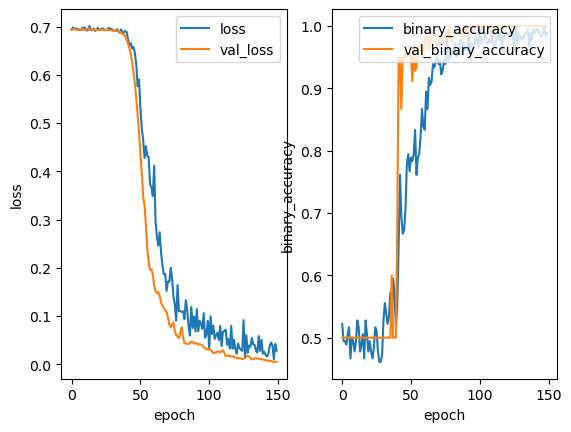

In [ ]:
utils.plot_history(history, ('loss', 'binary_accuracy'));


In [ ]:
out = abstractor_model(X_train)
yhat = np.array([int(o) for o in np.round(np.squeeze(out.numpy()))])
print('train accuracy: %.2f%%\n' % (100*np.mean(yhat==y_train)))

train accuracy: 100.00%



In [ ]:
out = abstractor_model(X_test)
yhat = np.array([int(o) for o in np.round(np.squeeze(out.numpy()))])
100*np.mean(yhat==y_test)
print('test accuracy: %.2f%%\n' % (100*np.mean(yhat==y_test)))

test accuracy: 100.00%



In [ ]:
out = abstractor_model.save_weights("models/larger_than_relation_weights")

In [ ]:
abstractor_model_ = AbstractorRMTSModel(embedding_dim, abstractor_kwargs, name='rmts_abstractor')
abstractor_model_.compile(loss='binary_crossentropy', optimizer=create_opt(), metrics=['binary_accuracy'])
abstractor_model_(X_train[:32])
abstractor_model_.load_weights('models/larger_than_relation_weights')
abstractor_model_.summary()

Model: "rmts_abstractor"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 cnn_encoder (CnnEncoder)    multiple                  104704    
                                                                 
 simple_abstractor (SimpleAb  multiple                 16768     
 stractor)                                                       
                                                                 
 flatten_42 (Flatten)        multiple                  0         
                                                                 
 hidden_layer (Dense)        multiple                  4128      
                                                                 
 final_layer (Dense)         multiple                  33        
                                                                 
Total params: 125,633
Trainable params: 20,929
Non-trainable params: 104,704
________________________________________

In [ ]:
out = abstractor_model_(X)
yhat = np.array([int(o) for o in np.round(np.squeeze(out.numpy()))])
print('Overall accuracy: %.2f%%\n' % (100*np.mean(yhat==y)))

Overall accuracy: 100.00%

